### Time Series Forecasting: ARMA & ARIMA

<strong>Functions Overview</strong>

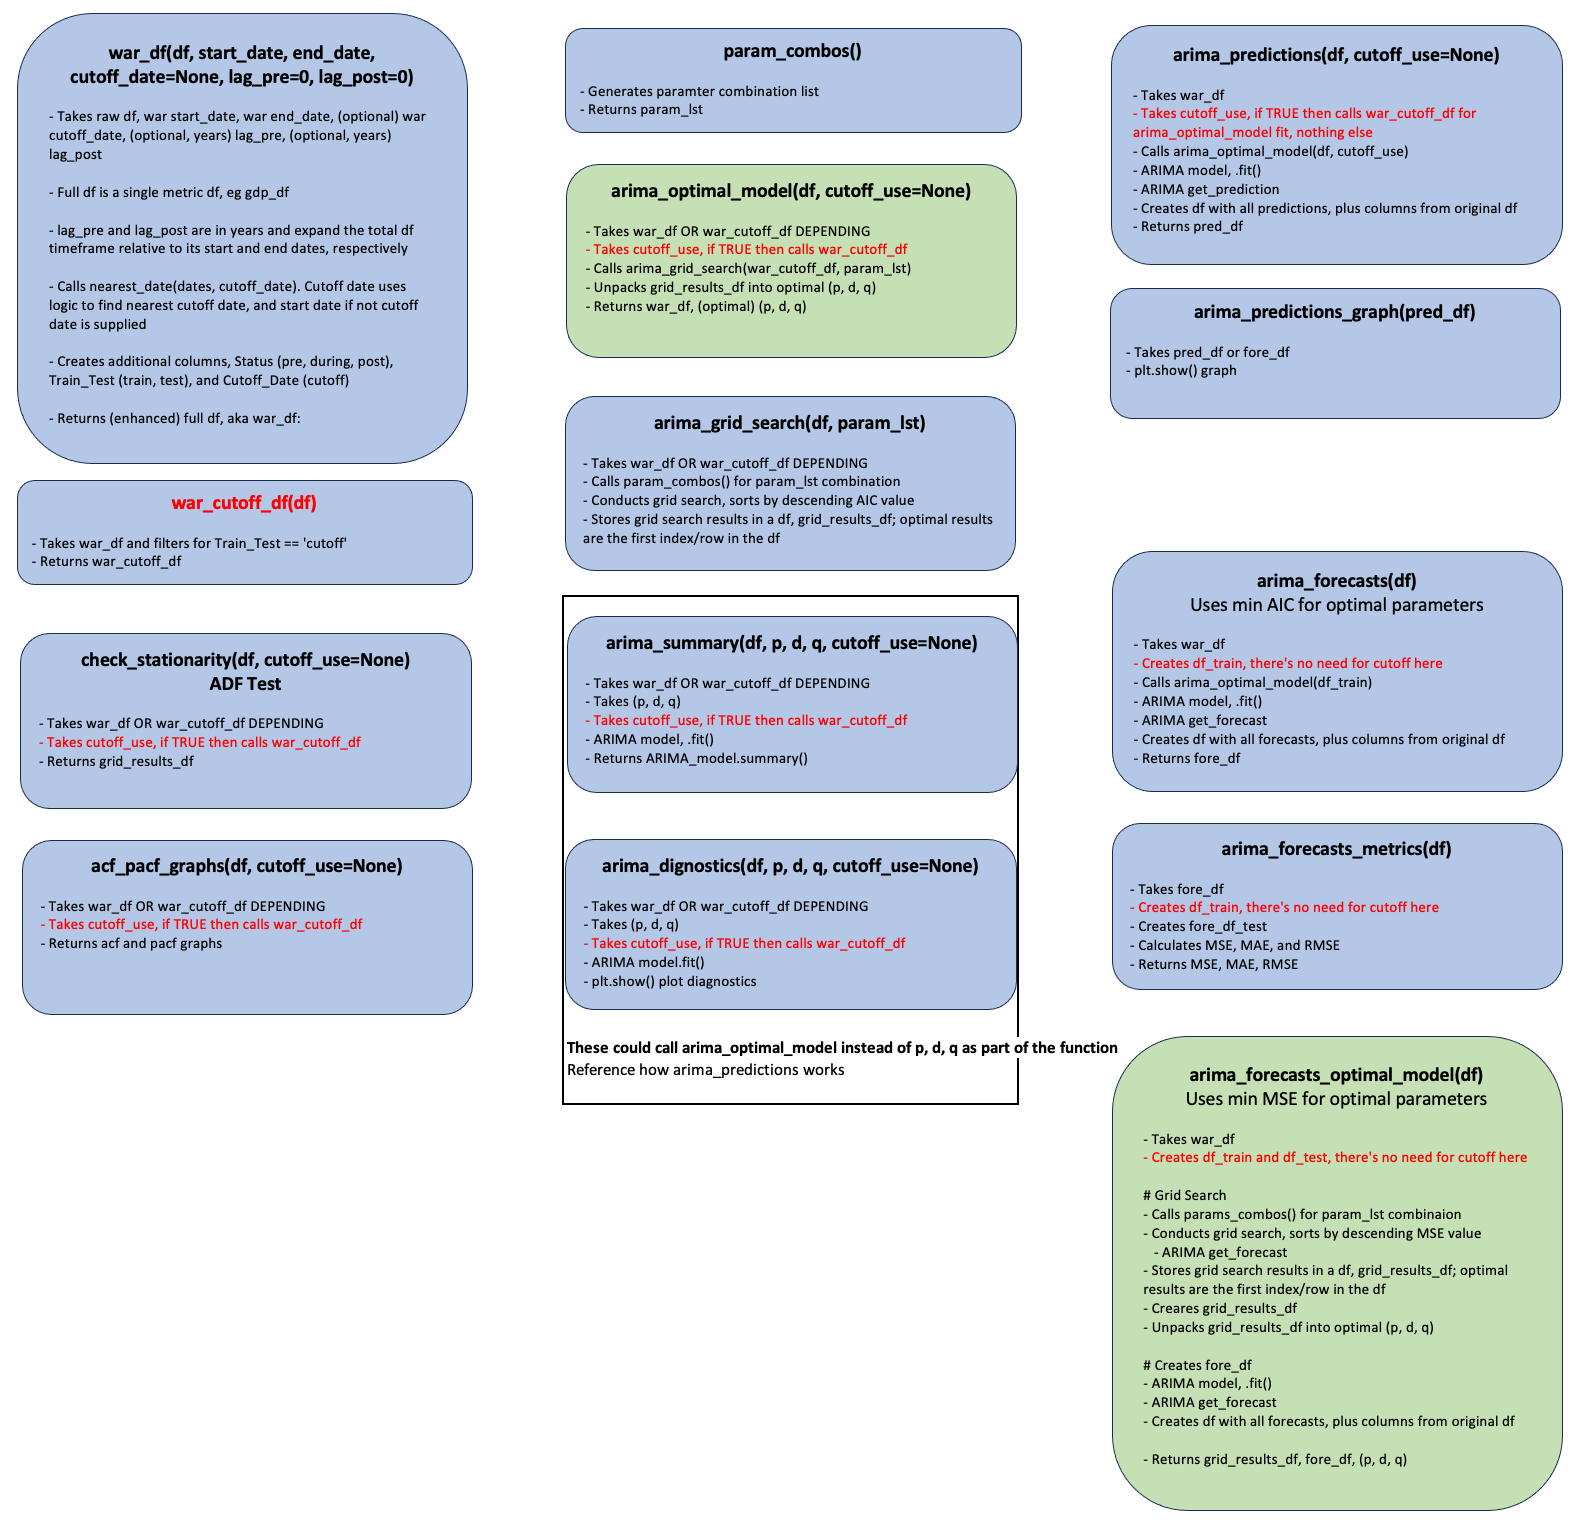

### 0. Prepare Data

<strong>Refresh Data Preparation Notebook & Variables</strong>

In [1]:
# Run Data Preperation Notebook
%run -i 0_Data_Preparation.py

# Import Stored Variables
%store -r cpi_df gdp_df fedrev_df pce_df fedfunds_df feddebt_df psave_df revolcredit_df unemploy_df infl_df cc_outstanding_df merged_df dataset_dict war_timeline_df war_dates_df

print('\nEconomic datasets:')
[print(v) for k, v in dataset_dict.items()]

print('\nmerged_df:')
merged_df.tail()

SyntaxError: name 'war_timeline_df' is used prior to global declaration (0_Data_Preparation.py, line 171)


Economic datasets:
cpi_df
gdp_df
fedrev_df
pce_df
fedfunds_df
feddebt_df
psave_df
revolcredit_df
cc_outstanding_df
unemploy_df
sgdp_df
infl_df

merged_df:


,DATE,CPI,GDP,FEDREV_mm_nom,PCE,FEDFUNDS,GFDEBTN,PSAVERT,REVOLSL,TOTALSL,UNRATE,SGDP,INFL
1033,2023-08-01,306.269,NaN,NaN,18689.9,5.33,NaN,4.2,1288.12390,4972.49265,3.8,NaN,3.707504
1034,2023-09-01,307.481,NaN,NaN,18823.4,5.33,NaN,3.7,1292.56745,4984.71756,3.8,NaN,3.689903
1035,2023-10-01,307.619,NaN,NaN,18864.7,5.33,NaN,3.8,1295.44619,4989.85178,3.9,NaN,3.232356
1036,2023-11-01,NaN,NaN,NaN,NaN,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,2024-01-01,NaN,NaN,5036380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<strong>Import Libraries</strong>

In [2]:
# Import Libraries
!pip install statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm_notebook
from itertools import product
import datetime
import dateutil.relativedelta
from dateutil import relativedelta
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1. Create War Dataframe

In [3]:
def war_df(df, start_date, end_date, cutoff_date=None, lag_pre=0, lag_post=0):

    # Calculate War Period & Dates
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    war_period = relativedelta.relativedelta(end_date, start_date)

    lag_pre = start_date - dateutil.relativedelta.relativedelta(years=lag_pre)
    lag_post = end_date + dateutil.relativedelta.relativedelta(years=lag_post)

    # Create War Dataframe
    df_all = df.loc[(df.DATE >= lag_pre.strftime('%Y-%m-%d')) & (df.DATE <= lag_post.strftime('%Y-%m-%d'))]

    # War Status
    df_all.loc[df.DATE < start_date.strftime('%Y-%m-%d'),'Status'] = 'pre'
    df_all.loc[df.DATE > end_date.strftime('%Y-%m-%d'),'Status'] = 'post'
    df_all.loc[(df.DATE >= start_date.strftime('%Y-%m-%d')) & (df.DATE <= end_date.strftime('%Y-%m-%d')),'Status'] = 'during'

    # War Cutoff Date
    df_all['Train_Test'] = np.nan

    if cutoff_date is not None:
        df_all.loc[df.DATE >= cutoff_date,'Train_Test'] = 'cutoff'
    else:
        cutoff_index = min(np.where(df_all.Status=='during'))[0]
        df_all.Train_Test.iloc[cutoff_index:] = 'cutoff'

    # War Train Test
    train_test_split = 0.25

    # Train Data
    df_all.loc[df_all.Train_Test.isna()==True,'Train_Test'] = 'train'
    train_test_count = len(df_all[df_all.Train_Test=='train'])

    # Test Data
    test_count = round(len(df_all[df_all.Train_Test=='train'])*train_test_split)
    df_all = df_all.reset_index(drop=True)
    df_all.loc[train_test_count-test_count:train_test_count-1,'Train_Test'] = 'test'   
    
    return df_all

In [4]:
# Separate DataFrame for Model Training
def war_cutoff_df(df):

    cutoff_index = np.where(df.Train_Test=='cutoff')[0][0]
    df_cutoff = df.iloc[:cutoff_index]

    return df_cutoff

### 2. Conduct Data Checks

In [5]:
# Augmented Dickey-Fuller (ADF) Test
def check_stationarity(df,cutoff_use=None, differencing=0):

    dfp = df.copy(deep=True)

    if cutoff_use == True:
        dfp = war_cutoff_df(dfp)

    if differencing > 0:
        dfp.iloc[:,1:2] = dfp.iloc[:,1:2].diff(differencing)
        dfp.dropna(inplace=True)

    adf = adfuller(dfp.iloc[:,1:2].values)

    print('ADF Statistic: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if (adf[1] <= 0.05) & (adf[4]['5%'] > adf[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [6]:
# ACF & PACF Graphs
def acf_pacf_graphs(df,cutoff_use=None, differencing=0):

    dfp = df.copy(deep=True)

    if cutoff_use == True:
        dfp = war_cutoff_df(dfp)

    if differencing > 0:
        dfp.iloc[:,1:2] = dfp.iloc[:,1:2].diff(differencing)
        dfp.dropna(inplace=True)

    fig, axes = plt.subplots(1, 2, figsize=(20,5))
    plot_acf(dfp.iloc[:,1:2].values.squeeze(), lags=10, ax=axes[0])
    plot_pacf(dfp.iloc[:,1:2].values.squeeze(), lags=10, ax=axes[1])
    plt.show()

### 3. Conduct Grid Search: Parameter Optimization

In [7]:
def param_combos():
    
    # Paramaters Combination List
    p = range(0,5,1)
    d = range(0,2,1)
    q = range(0,5,1)
    
    param_lst = list(product(p,d,q))

    return param_lst

In [8]:
def arima_grid_search(df):
    
    param_lst = param_combos()
    grid_results = []

    for order in (param_lst):
        try:
            ARIMA_model = ARIMA(df.iloc[:,1:2], order=order, enforce_stationarity=True).fit()
        except:
            continue

        aic = ARIMA_model.aic
        grid_results.append([order, aic])

    grid_results_df = pd.DataFrame(grid_results, columns=['(p,d,q)', 'aic'])
    grid_results_df = grid_results_df.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return grid_results_df

> arima_optimal_model is the primary function for model optimization using min AIC.

In [9]:
def arima_optimal_model(df,cutoff_use=None):
    
    # Separate DataFrame for Cutoff
    if cutoff_use == True:
        cutoff_df = war_cutoff_df(df)
        grid_results = arima_grid_search(cutoff_df)
    else:
        grid_results = arima_grid_search(df)

    # Optimal Parameters
    (p, d, q) = grid_results.iloc[0,0] # output of grid search

    return df, (p, d, q), grid_results

### 4. Best Model Summary & Diagnostics

In [10]:
def arima_summary(df,p,d,q,cutoff_use=None):
    
    if cutoff_use == True:
        df = war_cutoff_df(df)
        
    ARIMA_model = ARIMA(df.iloc[:,1:2], order=(p,d,q), enforce_stationarity=True).fit()
    
    return ARIMA_model.summary()

In [11]:
def arima_diagnostics(df,p,d,q, cutoff_use=None):
    
    if cutoff_use == True:
        df = war_cutoff_df(df)

    ARIMA_model = ARIMA(df.iloc[:,1:2], order=(p,d,q), enforce_stationarity=True).fit()
    
    ARIMA_model.plot_diagnostics(figsize=(10,7))
    plt.tight_layout()
    plt.show()

### 5. Best Model Predictions

In [12]:
def arima_predictions(df,cutoff_use=None):

    dfp = df.copy(deep=True)

    if cutoff_use == True:
        dfp, (p, d, q), grid_results = arima_optimal_model(dfp,cutoff_use=True)
    else:
        dfp, (p, d, q), grid_results = arima_optimal_model(dfp)

    ARIMA_model = ARIMA(dfp.iloc[:,1:2], order=(p,d,q), enforce_stationarity=True).fit()
    pred_df = pd.DataFrame(columns=['DATE','Status','Train_Test','Actual','Lower','Upper','Predict_Mean'])
    pred_df.DATE = dfp.DATE
    pred_df.Actual = dfp.iloc[:,1:2]
    pred_df.Status = dfp.Status
    pred_df.Train_Test = dfp.Train_Test

    # Get Prediction
    pred_df['Predict_Mean'] = ARIMA_model.predict(start=dfp[dfp.Train_Test == 'cutoff'].index[0], end=dfp.index[-1], dynamic=True)

    # Get Prediction Confidence Intervals
    pred = ARIMA_model.get_prediction(start=dfp[dfp.Train_Test == 'cutoff'].index[0], end=dfp.index[-1], dynamic=True)
    pred_ci = pred.conf_int(alpha=0.05)
    pred_df['Upper'] = pred_ci.iloc[:,1:]
    pred_df['Lower'] = pred_ci.iloc[:,:1]

    return pred_df


In [13]:
def arima_predictions_graph(pred_df, war_end=False, steps_xaxis=None):

    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(pred_df.DATE, pred_df.Actual, label='Actual')
    ax.plot(pred_df.DATE, pred_df.Predict_Mean, label='Predicted')

    # War Begins
    hidx = pred_df[pred_df.Status == 'during']['Actual'].iloc[0]*1.2
    ax.text(pred_df[pred_df.Status == 'during'].DATE.iloc[0], hidx, '  War Begins', ha='left')
    plt.axvline(pred_df[pred_df.Status == 'during'].DATE.iloc[0])

    if war_end == True:
        # War Ends
        hidx = pred_df[pred_df.Status == 'during']['Actual'].iloc[-1]*1.1
        ax.text(pred_df[pred_df.Status == 'during'].DATE.iloc[-1], hidx, '  War Ends', ha='left')
        plt.axvline(pred_df[pred_df.Status == 'during'].DATE.iloc[-1])

    # Prediction Intervals
    ax.fill_between(pred_df.DATE, pred_df.Upper, pred_df.Lower, color='k', alpha=0.1)
    ax.legend()

    # X Axis Step Size
    date_lst = pred_df.DATE.tolist()
    if steps_xaxis != None:
        date_lst = date_lst[0::steps_xaxis]

    ax.set_xticks(date_lst)
    plt.xticks(rotation=45)

    plt.show()

### 6. Best Model Forecasts

> Forecasting using min AIC.

In [14]:
# Uses Min AIC for Optimal Parameters
def arima_forecasts(df):

    df_train = df[df.Train_Test == 'train']
    df_test = df[df.Train_Test == 'test']

    # Call for optimal parameters, note you're cutting off at Train_Test == 'train', there's not use of cutoff
    df_do_not_use, (p, d, q), grid_results = arima_optimal_model(df_train)

    ARIMA_model = ARIMA(df_train.iloc[:,1:2], order=(p,d,q), enforce_stationarity=True).fit()
    fore_df = pd.DataFrame(columns=['DATE','Status','Train_Test','Actual','Lower','Upper','Predict_Mean'])
    fore_df.DATE = df.DATE
    fore_df.Status = df.Status
    fore_df.Train_Test = df.Train_Test
    fore_df.Actual = df.iloc[:,1:2]

    # Get Forecast
    forecast_steps = len(df[df.Status=='during']) + len(df[(df.Train_Test=='test') & (df.Status!='during')]) + 2
    fore_df.Upper = ARIMA_model.get_forecast(forecast_steps).conf_int(alpha=0.05).iloc[:,1:]
    fore_df.Lower = ARIMA_model.get_forecast(forecast_steps).conf_int(alpha=0.05).iloc[:,:1]
    fore_df.Predict_Mean = ARIMA_model.get_forecast(forecast_steps).predicted_mean
    
    return fore_df

In [15]:
def arima_forecasts_metrics(df):

    fore_test_df = df[df.Train_Test=='test']
    mse = mean_squared_error(fore_test_df.Actual, fore_test_df.Predict_Mean)
    print('MSE: '+str(mse))

    mae = mean_absolute_error(fore_test_df.Actual, fore_test_df.Predict_Mean)
    print('MAE: '+str(mae))

    rmse = math.sqrt(mean_squared_error(fore_test_df.Actual, fore_test_df.Predict_Mean))
    print('RMSE: '+str(rmse))

    return mse, mae, rmse

> Forecasting using min MSE, MAE, or RMSE.

In [16]:
# Uses Min MSE for Optimal Parameters
def arima_forecast_optimal_model(df, eval_metric='mse'):

    dff = df.copy(deep=True)

    param_lst = param_combos()
    grid_results = []

    df_train = dff[dff.Train_Test == 'train']
    df_test = dff[dff.Train_Test == 'test']

    p = 0
    d = 1
    q = 4

    history_endog = list(df_train.iloc[:,1:2].to_numpy().flatten())
    y_true = []
    y_pred = []

    for i, r in df_test.iloc[:,1:2].iterrows():  
        ARIMA_model = ARIMA(endog=history_endog, order=(p,d,q)).fit()
        forecast = ARIMA_model.forecast()[0]

        y_true.append(r[0])
        y_pred.append(forecast)
        history_endog.append(r[0])

    return y_true, y_pred

In [17]:
 # arima_forecast_optimal_model(vietnam_war_df)
# list(vietnam_war_df.iloc[:,1:2].to_numpy().flatten())

In [18]:
def hide():
    # arima_forecast_optimal_model(vietnam_war_df)
    vietnam_war_df

    dff = vietnam_war_df.copy(deep=True)

    df_train = dff[dff.Train_Test == 'train']
    df_test = dff[dff.Train_Test == 'test']

    p = 0
    d = 1
    q = 4

    history_endog = list(df_train.iloc[:,1:2].to_numpy().flatten())
    y_true = []
    y_pred = []

    for i, r in df_test.iloc[:,1:2].iterrows(): 
        ARIMA_model = ARIMA(endog=history_endog, order=(p,d,q)).fit()
        forecast = ARIMA_model.forecast()[0]

        y_true.append(r[0])
        y_pred.append(forecast)
        history_endog.append(r[0])

    print(df_test)
    pd.DataFrame(zip(history_endog,y_true, y_pred), columns=['y_train','y_true', 'y_pred'])

In [19]:
# Uses Min MSE for Optimal Parameters
def arima_forecasts_optimal_model(df, eval_metric='mse'):

    param_lst = param_combos()
    grid_results = []

    df_train = df[df.Train_Test == 'train']
    df_test = df[df.Train_Test == 'test']

    for order in (param_lst):
        try:
            ARIMA_model = ARIMA(df_train.iloc[:,1:2], order=order, enforce_stationarity=True).fit()
        except:
            continue

        aic = ARIMA_model.aic

        # Get Forecast 
        y_fore = ARIMA_model.get_forecast(len(df_test)).predicted_mean
        df_test['Predict_Mean'] = y_fore

        # Forecast Metrics
        mse = mean_squared_error(df_test.iloc[:,1:2].values, df_test.Predict_Mean)
        mae = mean_absolute_error(df_test.iloc[:,1:2].values, df_test.Predict_Mean)
        rmse = math.sqrt(mean_squared_error(df_test.iloc[:,1:2].values, df_test.Predict_Mean))

        grid_results.append([order, mse, mae, rmse, aic])

    grid_results_df = pd.DataFrame(grid_results, columns=['(p,d,q)','mse','mae','rmse','aic']) 
    grid_results_df = grid_results_df.sort_values(by=eval_metric, ascending=True).reset_index(drop=True)

    # Optimal Parameters
    (p, d, q) = grid_results_df.iloc[0,0] # output of grid search

    # Create fore_df
    ARIMA_model = ARIMA(df_train.iloc[:,1:2], order=(p,d,q), enforce_stationarity=True).fit()
    fore_df = pd.DataFrame(columns=['DATE','Status','Train_Test','Actual','Lower','Upper','Predict_Mean'])
    fore_df.DATE = df.DATE
    fore_df.Status = df.Status
    fore_df.Train_Test = df.Train_Test
    fore_df.Actual = df.iloc[:,1:2]

    # Get Forecast
    forecast_steps = len(df[df.Status=='during']) + len(df[(df.Train_Test=='test') & (df.Status!='during')]) + 2
    fore_df.Upper = ARIMA_model.get_forecast(forecast_steps).conf_int(alpha=0.05).iloc[:,1:]
    fore_df.Lower = ARIMA_model.get_forecast(forecast_steps).conf_int(alpha=0.05).iloc[:,:1]
    fore_df.Predict_Mean = ARIMA_model.get_forecast(forecast_steps).predicted_mean

    return grid_results_df, fore_df, (p, d, q)

## Vietnam War & Afghanistan War Analysis

In [20]:
# Create War Dataframes
all_war_df = war_df(gdp_df, '1947-01-01', '2023-07-01')
vietnam_war_df = war_df(gdp_df, '1955-11-01', '1975-04-30', lag_pre=10, lag_post=10)
afghan_war_df = war_df(gdp_df, '2001-10-07', '2021-08-30', lag_pre=20, lag_post=10)

# SELECT WAR DF
select_war_df = afghan_war_df.copy(deep=True)

In [21]:
# Conduct Data Checks
check_stationarity(select_war_df, cutoff_use=True, differencing=1)

ADF Statistic: -3.205211
p-value: 0.019685
Critical Values:
	1%: -3.518
	5%: -2.900
	10%: -2.587
Stationary


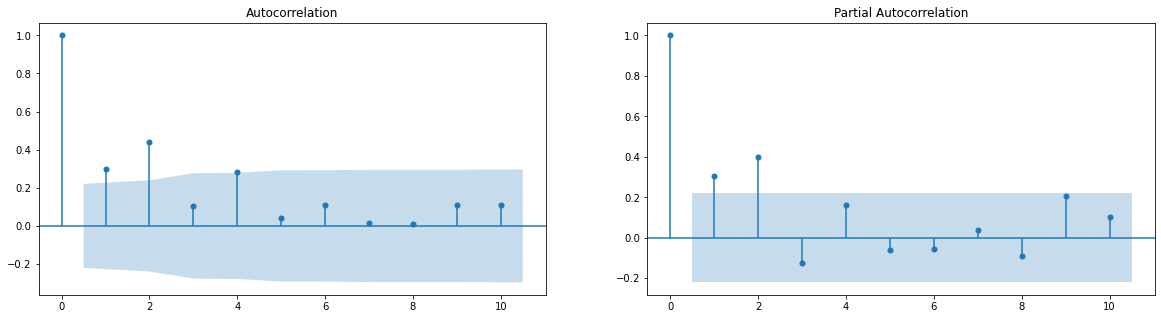

In [22]:
# ACF & PACF Graphs
acf_pacf_graphs(select_war_df, cutoff_use=True, differencing=1)

In [23]:
# Optimal Parameters from Grid Search (no longer directly call)
# vietnam_results = arima_grid_search(vietnam_war_df, param_lst)
# vietnam_results = arima_grid_search(vietnam_war_df[vietnam_war_df.Train_Test=='train'], param_lst)
# (p, d, q) = vietnam_results.iloc[0,0] # output of grid search

# Optimal Parameters (using min AIC)
df, (p, d, q), grid_results = arima_optimal_model(select_war_df, cutoff_use=True)

# Best Model Summary (using min AIC)
print('ARIMA{}'.format((p, d, q)))
print(arima_summary(select_war_df,p,d,q))
grid_results.head()

ARIMA(3, 1, 3)
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  167
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1137.553
Date:                Thu, 14 Dec 2023   AIC                           2289.107
Time:                        02:33:28   BIC                           2310.891
Sample:                             0   HQIC                          2297.949
                                - 167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5012      0.258     -1.941      0.052      -1.007       0.005
ar.L2          0.7636      0.271      2.822      0.005       0.233       1.294
ar.L3          0.7269      0.288     

,"(p,d,q)",aic
0,"(3, 1, 3)",802.270291
1,"(4, 1, 0)",803.092538
2,"(3, 1, 2)",803.850975
3,"(2, 1, 2)",804.702478
4,"(2, 1, 3)",804.807527


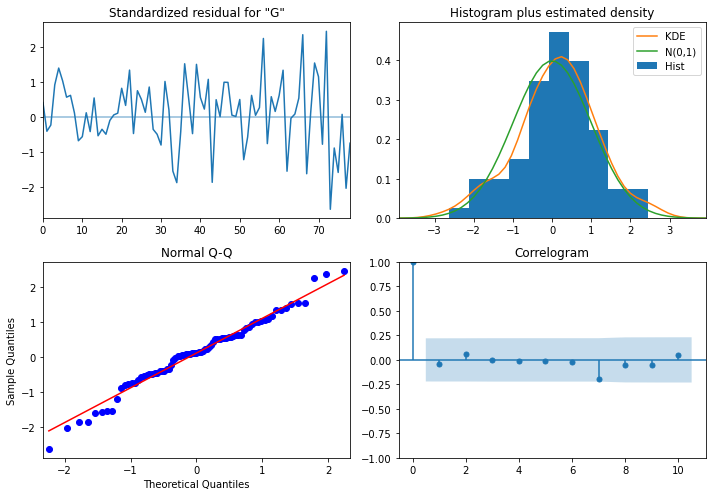

In [24]:
# Model Diagnostics: Standard Residual & Correlogram (ACF) for Correlation, Histogram & Q-Q for Normality
arima_diagnostics(select_war_df,p,d,q,cutoff_use=True)

In [25]:
# Predictions Dataframe
pred_df = arima_predictions(select_war_df,cutoff_use=True)
pred_df.head()

,DATE,Status,Train_Test,Actual,Lower,Upper,Predict_Mean
0,1982-01-01,pre,train,3274.302,NaN,NaN,NaN
1,1982-04-01,pre,train,3331.972,NaN,NaN,NaN
2,1982-07-01,pre,train,3366.322,NaN,NaN,NaN
3,1982-10-01,pre,train,3402.561,NaN,NaN,NaN
4,1983-01-01,pre,train,3473.413,NaN,NaN,NaN


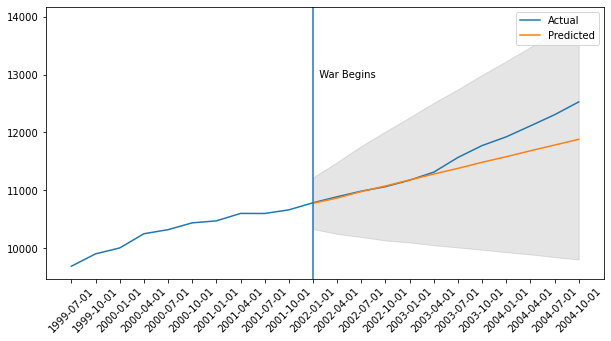

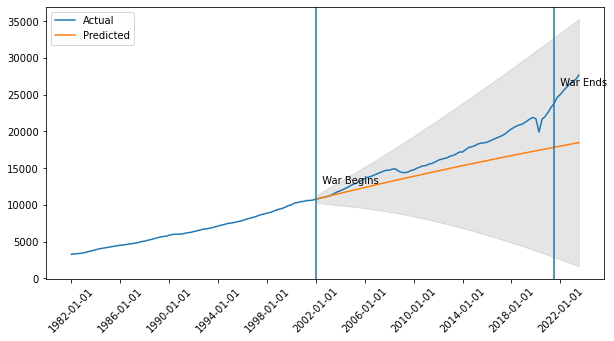

,DATE,Status,Train_Test,Actual,Lower,Upper,Predict_Mean
80,2002-01-01,during,cutoff,10783.500,10328.834717,11220.699090,10774.766904
81,2002-04-01,during,cutoff,10887.460,10244.087153,11486.064178,10865.075666
82,2002-07-01,during,cutoff,10984.040,10191.158327,11765.079731,10978.119029
83,2002-10-01,during,cutoff,11061.433,10130.876625,12016.132870,11073.504748
84,2003-01-01,during,cutoff,11174.129,10096.142137,12259.179120,11177.660628
85,2003-04-01,during,cutoff,11312.766,10049.019375,12511.906267,11280.462821
86,2003-07-01,during,cutoff,11566.669,10010.619835,12744.990839,11377.805337
87,2003-10-01,during,cutoff,11772.234,9971.778920,12994.672136,11483.225528
88,2004-01-01,during,cutoff,11923.447,9927.932467,13230.955722,11579.444094
89,2004-04-01,during,cutoff,12112.815,9889.824082,13475.124316,11682.474199


In [26]:
# Predictions Graph
arima_predictions_graph(pred_df.iloc[70:-75,:], war_end=False, steps_xaxis=None)
arima_predictions_graph(pred_df.iloc[:,:], war_end=True, steps_xaxis=16)
pred_df[pred_df.Status=='during'].head(15)

> Forecasting

In [27]:
# Forecast Dataframe
fore_df = arima_forecasts(select_war_df)
fore_df

,DATE,Status,Train_Test,Actual,Lower,Upper,Predict_Mean
0,1982-01-01,pre,train,3274.302,NaN,NaN,NaN
1,1982-04-01,pre,train,3331.972,NaN,NaN,NaN
2,1982-07-01,pre,train,3366.322,NaN,NaN,NaN
3,1982-10-01,pre,train,3402.561,NaN,NaN,NaN
4,1983-01-01,pre,train,3473.413,NaN,NaN,NaN
...,...,...,...,...,...,...,...
162,2022-07-01,post,cutoff,25994.639,NaN,NaN,NaN
163,2022-10-01,post,cutoff,26408.405,NaN,NaN,NaN
164,2023-01-01,post,cutoff,26813.601,NaN,NaN,NaN
165,2023-04-01,post,cutoff,27063.012,NaN,NaN,NaN


> Forecasting using min AIC

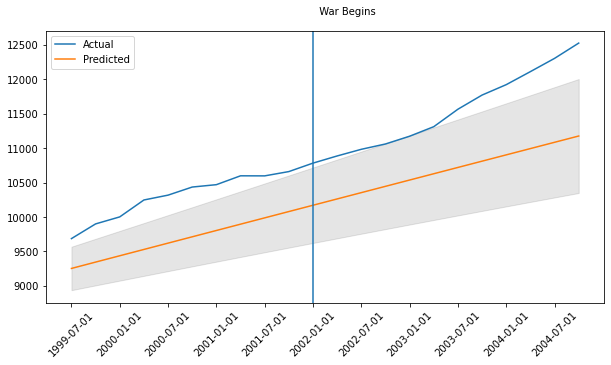

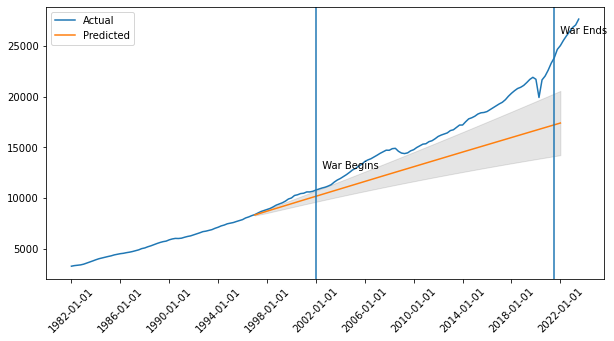

,DATE,Status,Train_Test,Actual,Lower,Upper,Predict_Mean
144,2018-01-01,during,cutoff,20328.553,13418.756615,18513.601673,15966.179144
145,2018-04-01,during,cutoff,20580.912,13470.560474,18640.697578,16055.629026
146,2018-07-01,during,cutoff,20798.730,13522.157649,18767.933378,16145.045514
147,2018-10-01,during,cutoff,20917.867,13573.549059,18895.308177,16234.428618
148,2019-01-01,during,cutoff,21104.133,13624.735614,19022.821091,16323.778352
149,2019-04-01,during,cutoff,21384.775,13675.718210,19150.471248,16413.094729
150,2019-07-01,during,cutoff,21694.282,13726.497738,19278.257783,16502.377761
151,2019-10-01,during,cutoff,21902.390,13777.075074,19406.179844,16591.627459
152,2020-01-01,during,cutoff,21706.513,13827.451087,19534.236588,16680.843837
153,2020-04-01,during,cutoff,19913.143,13877.626635,19662.427180,16770.026907


In [28]:
# Forecast Graph using min AIC
arima_predictions_graph(fore_df.iloc[70:-75,:], war_end=False, steps_xaxis=2)
arima_predictions_graph(fore_df.iloc[:,:], war_end=True, steps_xaxis=16)
fore_df[fore_df.Status=='during'].tail(15)

In [29]:
# Forecast Performance using min AIC
arima_forecasts_metrics(fore_df)

MSE: 225388.52809200194
MAE: 414.5667215422216
RMSE: 474.75101694678017


(225388.52809200194, 414.5667215422216, 474.75101694678017)

> Forecasting using min MSE, MAE, or RMSE

In [30]:
# Best Model Summary (using min MSE, MAE, or RMSE)
grid_results_df, fore_df, (p, d, q) = arima_forecasts_optimal_model(select_war_df, eval_metric='mse')
grid_results_df.head()

,"(p,d,q)",mse,mae,rmse,aic
0,"(1, 1, 1)",74570.852453,220.414612,273.076642,578.324855
1,"(2, 1, 2)",89296.189115,241.405180,298.824680,581.925100
2,"(4, 1, 0)",107175.874287,265.099463,327.377266,580.512110
3,"(1, 1, 2)",139379.803486,317.336311,373.336046,579.048225
4,"(3, 1, 4)",163248.462973,348.318872,404.040175,586.915343


In [31]:
# Best Model Summary (using min MSE, MAE, or RMSE)
grid_results_df, foreo_df, (p, d, q) = arima_forecasts_optimal_model(select_war_df, eval_metric='mse')

print('ARIMA{}'.format((p, d, q)))
print(arima_summary(select_war_df,p,d,q))

ARIMA(1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  167
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1139.778
Date:                Thu, 14 Dec 2023   AIC                           2285.556
Time:                        02:33:54   BIC                           2294.892
Sample:                             0   HQIC                          2289.345
                                - 167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9971      0.006    155.653      0.000       0.985       1.010
ma.L1         -0.9335      0.021    -44.726      0.000      -0.974      -0.893
sigma2      5.322e+04   1576.377     

In [32]:
# Forecast Dataframe
foreo_df[(foreo_df.Train_Test=='test') | (foreo_df.Status=='during')].head(15)

,DATE,Status,Train_Test,Actual,Lower,Upper,Predict_Mean
60,1997-01-01,pre,test,8362.655,8316.627933,8435.405119,8376.016526
61,1997-04-01,pre,test,8518.825,8388.089991,8593.957363,8491.023677
62,1997-07-01,pre,test,8662.823,8455.251090,8754.360202,8604.805646
63,1997-10-01,pre,test,8765.907,8517.464431,8917.286538,8717.375484
64,1998-01-01,pre,test,8866.480,8574.825160,9082.667052,8828.746106
65,1998-04-01,pre,test,8969.699,8627.559447,9250.301124,8938.930285
66,1998-07-01,pre,test,9121.097,8675.908086,9419.973238,9047.940662
67,1998-10-01,pre,test,9293.991,8720.098379,9591.481101,9155.789740
68,1999-01-01,pre,test,9411.682,8760.338045,9764.641740,9262.489892
69,1999-04-01,pre,test,9526.210,8796.815371,9939.291343,9368.053357


(p,d,q)    (1, 1, 1)
mse          74570.9
mae          220.415
rmse         273.077
aic          578.325
Name: 0, dtype: object


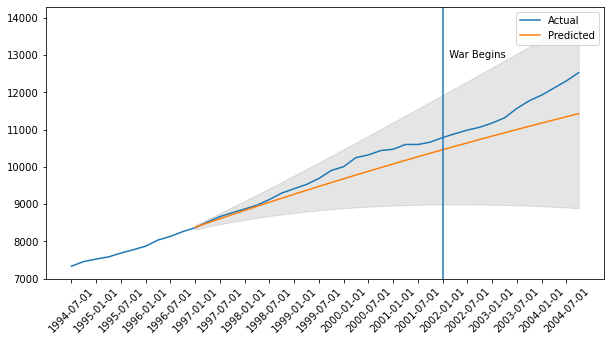

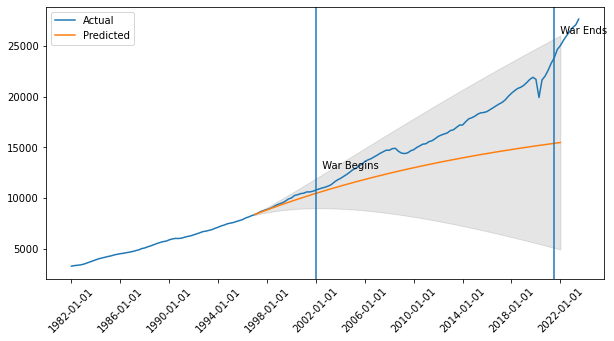

,DATE,Status,Train_Test,Actual,Lower,Upper,Predict_Mean
144,2018-01-01,during,cutoff,20328.553,6146.312592,23415.680045,14780.996318
145,2018-04-01,during,cutoff,20580.912,6073.148653,23582.392554,14827.770603
146,2018-07-01,during,cutoff,20798.730,5999.485466,23748.607729,14874.046598
147,2018-10-01,during,cutoff,20917.867,5925.334631,23914.324587,14919.829609
148,2019-01-01,during,cutoff,21104.133,5850.707521,24079.542258,14965.124890
149,2019-04-01,during,cutoff,21384.775,5775.615287,24244.259983,15009.937635
150,2019-07-01,during,cutoff,21694.282,5700.068863,24408.477110,15054.272986
151,2019-10-01,during,cutoff,21902.390,5624.078969,24572.193088,15098.136029
152,2020-01-01,during,cutoff,21706.513,5547.656120,24735.407468,15141.531794
153,2020-04-01,during,cutoff,19913.143,5470.810627,24898.119893,15184.465260


In [33]:
# Forecast Graph using min MSE
print(grid_results_df.iloc[0])


arima_predictions_graph(foreo_df.iloc[50:-75,:], war_end=False, steps_xaxis=2)
arima_predictions_graph(foreo_df.iloc[:,:], war_end=True, steps_xaxis=16)
foreo_df[foreo_df.Status=='during'].tail(15)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba1e4b21-f3e5-4d67-887d-75e6f1b74e8f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>